here I use a guide from https://course.fast.ai/ 
https://github.com/fastai/fastbook/blob/master/02_production.ipynb 


# Image-Classification

In [1]:
from fastai.vision.all import *
from fastdownload import download_url
from time import sleep
from fastai.vision.all import DataBlock, ImageBlock, CategoryBlock, RandomSplitter, get_image_files, parent_label, Resize
from fastcore.all import *
from duckduckgo_search import DDGS
from fastai.vision.widgets import *
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt



# 1. Bilder downloaden fürs Model-trainieren

In [2]:
# if this code does give an error-message then just run it a second time 

#Quelle: https://forums.fast.ai/t/duckduckgo-search-not-working/105738/39?page=2
def search_images(term, max_images=200):
    with DDGS(headers = {"Accept-Encoding": "gzip, deflate, br"}) as ddgs:
        results = ddgs.images(keywords=term)[0:max_images]  #ist kein iterator - das ist rin problem
        images = [res.get("image") for res in results] 
        return L(images)

In [103]:
dict_suchbegriff = {'bicycle': ['bicycle'],
                    'bus': ['Bus Verkehr', 'Stadtbus', 'Bus wiener linien'],
                    'car': ['Auto kaufen', 'Auto']
                    }
#je Suchbegriff werden 200 Bilder runtergeladen

path = Path('bicycle_bus_or_car') #Pfad in dem sie gespeichert werden

for category, suchbegriffe in dict_suchbegriff.items():
    dest = (path/category)   #Fotos zu jede Kategorie werden in einem eigenen Ordner gespeichert
    if not dest.exists(): #falls es den Ordner noch nicht gibt
        dest.mkdir(exist_ok=True, parents=True) #erstellt Ordner

        for suchbegriff in suchbegriffe:
            download_images(dest, urls=search_images(suchbegriff))
            sleep(10)  # Pause between searches to avoid over-loading server

        resize_images(path/category, max_size=400, dest=path/category) #resize so it is much faster

In [5]:
# to check if folder has image files
get_image_files(path)

(#996) [Path('bicycle_bus_or_car/car/194f40c4-74db-4d7c-b3d3-cc5addd62782.jpg'),Path('bicycle_bus_or_car/car/2ea84aa6-3d4f-4878-af1e-85b37812b111.JPG'),Path('bicycle_bus_or_car/car/c78181cd-8db6-48db-b22a-a40b222545a2.jpg'),Path('bicycle_bus_or_car/car/6c8834ef-35b2-4f03-90ba-1ce48daa1468.png'),Path('bicycle_bus_or_car/car/edf08f94-141f-4f47-9299-c92fbdd143e4.jpg'),Path('bicycle_bus_or_car/car/2cd2edf2-c17c-4392-8c1a-5be0476413b5.jpg'),Path('bicycle_bus_or_car/car/4c607da3-9eac-4e4d-b903-b98131210782.jpg'),Path('bicycle_bus_or_car/car/e18cf0c0-ca75-4474-a1ea-289e408aeabc.jpg'),Path('bicycle_bus_or_car/car/298f301f-99be-49a5-9533-c8bb029ea61a.jpg'),Path('bicycle_bus_or_car/car/db02f7f4-7217-464e-8ca4-0149ef683c6d.jpg')...]

# 2. Train our model

In [105]:
# Verify and remove any corrupted or incomplete images to avoid issues during model training.

failed = verify_images(get_image_files(path))  # Identify failed image files.
print(len(failed))  # Return the count of failed images that were removed.

failed.map(Path.unlink)  # Delete the identified corrupted image files.

0


(#0) []

In [106]:
#DataBlock: question how to get this data in my model. 
data_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock), #specify that the inputs to our model are images, and the outputs are categories
    get_items=get_image_files, #takes a path, and returns a list of all of the images in that path 
    splitter=RandomSplitter(valid_pct=0.2, seed=42), #80% training set and 20% validation set (=to check the accuracy of a model)
    get_y=parent_label, # Function to determine the labels for the images
    item_tfms=Resize(128) # Resize images to a uniform size
)

#say where the path is where the images can be found
data_loaders = data_block.dataloaders(path)

#data_loaders.show_batch(max_n=10, nrows=2) #show me a few images

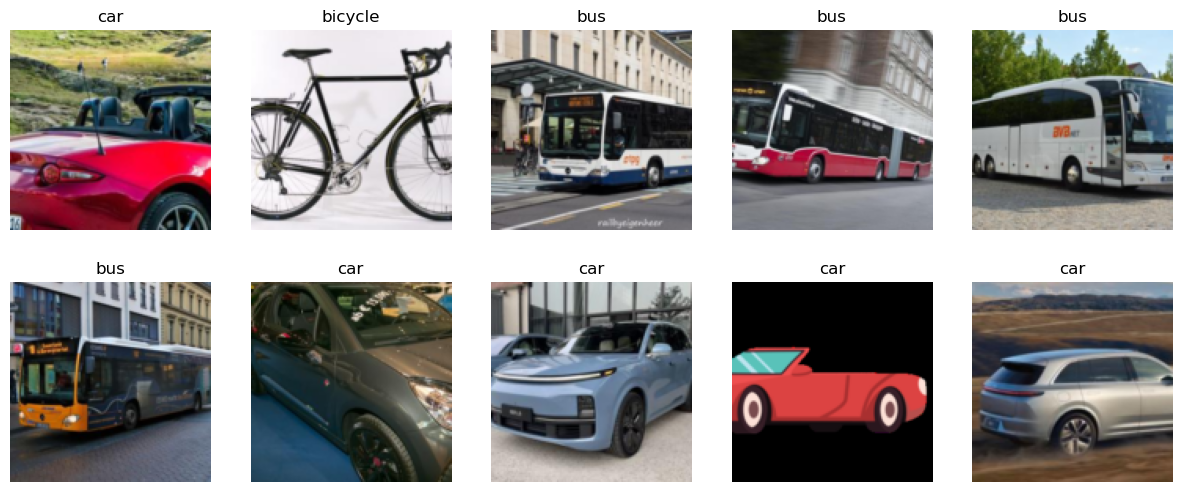

In [107]:
data_loaders.show_batch(max_n=10, nrows=2) #show me a few images

### train the model

In [108]:
# Create a learner using the vision_learner function with the specified model and metrics
learner = vision_learner(dls=data_loaders, arch=resnet18, metrics=error_rate)

# Fine-tune the model for 4 epochs
learner.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.092481,0.100319,0.034314,00:02


epoch,train_loss,valid_loss,error_rate,time
0,0.230165,0.054882,0.024510,00:03
1,0.136280,0.022900,0.009804,00:03
2,0.088485,0.030165,0.009804,00:03
3,0.067969,0.023701,0.004902,00:03


# 3. predictions

#### einzelne Bilder downloaden um vorhersagen zu machen

In [6]:
# ich weiß nich nicht ob so wie ich das geschrieben habe funktioniert. das muss ich noch testen. gegebenfalls sind hier fehler drinnen

def download_img(suchbegriff):
    """
    This function searches for an image using DuckDuckGo's image search API, downloads the first image result,
    saves it to a local file, and returns a resized image.
    """
    

    #getting URLs from a search:
    #NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
    #If you get a JSON error, just try running it again (it may take a couple of tries).
    urls = search_images(suchbegriff, max_images=1)
    #look at the URL
    print(urls[0])

    ziel_datei  = "Bsp_" + suchbegriff.replace(" ","_") + ".jpg"

    #download URL
    download_url(urls[0], ziel_datei, show_progress=False)

    #have a look at the foto
    im = Image.open(ziel_datei)
    return im.to_thumb(256,256)

#### predictions

In [110]:
# ich weiß nich nicht ob so wie ich das geschrieben habe funktioniert. das muss ich noch testen. gegebenfalls sind hier fehler drinnen

def vorhersage(foto):
    """
    Takes an Image-Dateiname as Input. returns both the predicted category and its associated probability.
    """
        
    prediction,_,probability_tuple = learner.predict(foto)

    categories = ('bicycle','bus','car') # sind alphabetisch geordnet 

    for index, category in enumerate(categories):
        if prediction == category:
            probability = probability_tuple[index] # probability_tuple[1] stands for "bus", [0] für bicycle, [2] für car

    return prediction, probability

#### ein einzelnes Fahrrad-Foto

http://staranddaisy.in/wp-content/uploads/2022/11/skillmax20in9123_mainblue.jpg


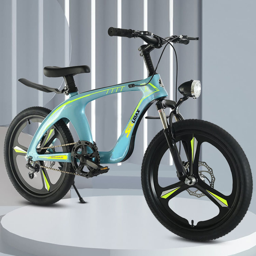

In [7]:
suchbegriff = 'bicycle'
download_img(suchbegriff)

In [ ]:
foto = 'Bsp_bicycle.jpg'

prediction, probability = vorhersage(foto)
print(f"This is a {prediction} with {probability:.4f} probability.")

This is a bicycle with 1.0000 probability.


#### ein einzelnes Bus-Foto

http://upload.wikimedia.org/wikipedia/commons/2/2f/Bangalore_Metropolitan_Transport_Corporation_Volvo_B7RLE_bus,_India.jpg


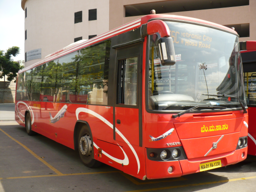

In [ ]:
suchbegriff = 'bus'
download_img(suchbegriff)

In [ ]:
foto = 'Bsp_bus.jpg'

prediction, probability = vorhersage(foto)
print(f"This is a {prediction} with {probability:.4f} probability.")

This is a bus with 0.9989 probability.


#### ein einzelnes Auto-Foto

https://images.hdqwalls.com/wallpapers/ferrari-458-italia-red-2018-pd.jpg


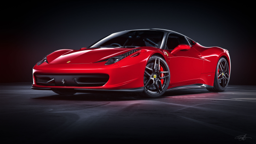

In [ ]:
suchbegriff = 'roter Ferrari'
download_img(suchbegriff)

In [ ]:
foto= 'Bsp_roter_Ferrari.jpg'

prediction, probability = vorhersage(foto)
print(f"This is a {prediction} with {probability:.4f} probability.") 

This is a car with 1.0000 probability.


# 4. export model in pkl-file

In [ ]:
#export the model

#learner.export('model_image-classifier.pkl')

In [ ]:
#check if the file exists
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('model_image-classifier.pkl')]

In [ ]:
#see the categories
#ich weiß nicht wieso dls da steht

learner.dls.vocab

['bicycle', 'bus', 'car']

#### import an pkl-file

In [ ]:
# how to importe the pkl-file back
learn_inf = load_learner('model_image-classifier.pkl')

#how to make predictions with the imported loader
learn_inf.predict('Bsp_bus.jpg')

('bus', tensor(1), tensor([8.6050e-04, 9.9913e-01, 5.8147e-06]))

---

---

---

---

---

---

### confusion matrix

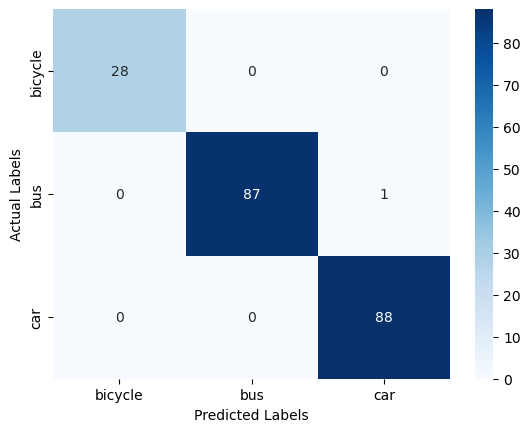

In [ ]:
# Erstelle Vorhersagen und tatsächliche Labels aus dem Modell
preds, actuals = learner.get_preds()

# Konvertiere die numerischen Labels in Kategorienamen
labels = learner.dls.vocab

# Berechne die Konfusionsmatrix
cm = confusion_matrix(actuals, preds.argmax(dim=1))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()

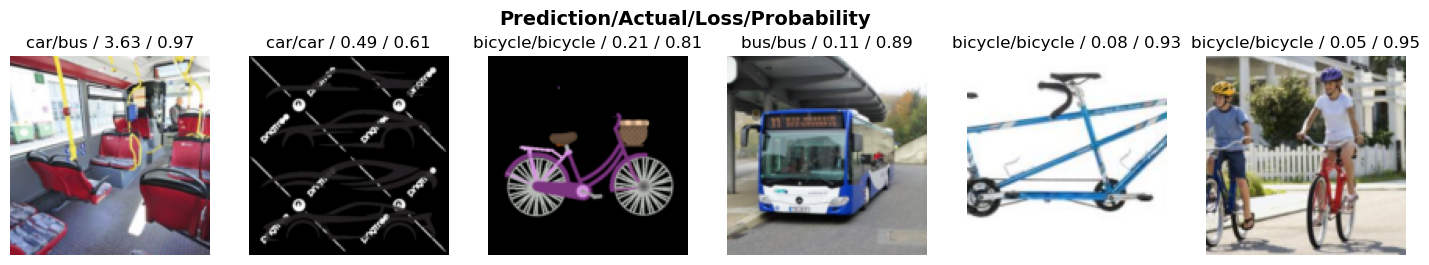

In [ ]:
interp = ClassificationInterpretation.from_learner(learner)

#shows where the loss is highest. have high loss by being wrong and confident or by being right and inconfident
interp.plot_top_losses(6, nrows=1)

# data-cleaning

In [114]:
#view the hightes-loss-images and i can manually decide if i want to keep or delete them
cleaner = ImageClassifierCleaner(learner)
cleaner

FileNotFoundError: [Errno 2] No such file or directory: '/Users/elisabeth/1_Lokale_Dateien/shared_TechLab/individual_notebooks/Prossinger/image_classification/bicycle_bus_or_car/bicycle/a510e6b3-c7e2-4c66-bdcf-c60ae942d670.jpg'

FileNotFoundError: [Errno 2] No such file or directory: '/Users/elisabeth/1_Lokale_Dateien/shared_TechLab/individual_notebooks/Prossinger/image_classification/bicycle_bus_or_car/car/b1fb079a-62a5-496b-976b-29cb5e4a5bff.png'

In [128]:
#to delete the images
for idx in cleaner.delete(): cleaner.fns[idx].unlink()


In [127]:
#for the images where we selected a different category - it will change their categorie

for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [129]:
cleaner